In [1]:
include("../code/headers.jl")

In [26]:
n = factorial(7)
k = 3:10
R = 1 .- 2 ./k
m_ = n*(1 .- R)
m = Int.(round.(m_))
m_

8-element Array{Float64,1}:
 3360.0
 2520.0
 2016.0
 1679.9999999999995
 1440.0
 1260.0
 1120.0
 1007.9999999999998

In [28]:
randseed = 123
algo = MS(maxiter=1000, Tmax=1, gamma=0.0, sigma=0.0)
Y = [rand([0,1], n) for mm in m]

8-element Array{Array{Int64,1},1}:
 [1, 1, 1, 1, 0, 1, 0, 1, 0, 1  …  1, 1, 1, 0, 0, 1, 1, 0, 0, 1]
 [1, 1, 0, 1, 1, 0, 1, 0, 0, 1  …  0, 1, 1, 0, 0, 0, 1, 0, 1, 0]
 [0, 0, 1, 1, 0, 1, 1, 0, 0, 1  …  0, 1, 1, 0, 0, 1, 1, 1, 1, 1]
 [1, 0, 1, 1, 1, 1, 0, 1, 1, 1  …  1, 0, 1, 1, 0, 0, 0, 0, 0, 1]
 [0, 1, 1, 1, 1, 0, 0, 1, 1, 0  …  0, 0, 0, 1, 0, 1, 1, 0, 1, 0]
 [0, 1, 0, 0, 1, 1, 0, 1, 1, 1  …  1, 1, 1, 0, 0, 1, 1, 1, 1, 0]
 [0, 1, 0, 0, 1, 0, 0, 1, 1, 1  …  0, 0, 1, 1, 1, 0, 0, 0, 1, 1]
 [1, 1, 0, 0, 0, 1, 0, 1, 1, 0  …  0, 1, 0, 0, 0, 1, 1, 0, 0, 0]

In [ ]:
res = Vector{BPResults{MS}}(undef, length(m))
msgs = [Float64[] for _ in m]
fgs = Vector{FactorGraph}(undef,length(m))
for j in eachindex(m)
    println("Rate $(round(R[j],digits=2)). $j of $(length(m))")
    fg = ldpc_graph(2, n, m[j], randseed=randseed)
    fg.fields .= extfields(fg.q,Y[j],algo,randseed=randseed+j)
    res[j] = bp!(fg, algo, Y[j], verbose=true)
    msgs[j] = [ms[end] for ms in fg.mfv]
    fgs[j] = deepcopy(fg)
end

Rate 0.33. 1 of 8


Trial 1/1   7%|███                                      |  ETA: 0:03:58

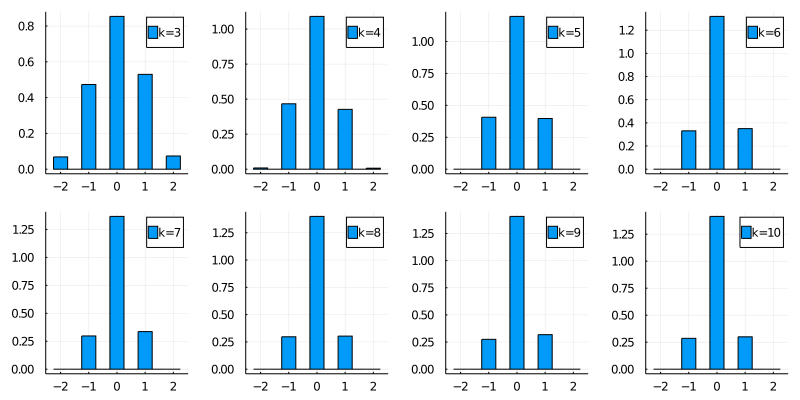

In [22]:
plts = []
bins = -2.25:0.5:2.25
levels = -6:6
cnts = []
dist = zeros(length(m))
for j in eachindex(m)
    push!(plts, histogram(msgs[j], label="k=$(k[j])", bins=bins, normalize=:pdf))
    push!(cnts, OffsetArray(StatsBase.proportions(Int.(msgs[j]), levels)))
    dist[j] = distortion(fgs[j], Y[j])
end
plot(plts..., layout=(2,4), size=(800,400))

In [23]:
cnts[1]

13-element OffsetArray(::Array{Float64,1}, 0:12) with eltype Float64 with indices 0:12:
 0.0
 0.0
 0.0
 0.00029761904761904765
 0.03422619047619048
 0.23660714285714288
 0.4267857142857143
 0.2648809523809524
 0.036904761904761905
 0.00029761904761904765
 0.0
 0.0
 0.0

In [24]:
[k dist]

8×2 Array{Float64,2}:
  3.0  0.249206
  4.0  0.187302
  5.0  0.185317
  6.0  0.1875
  7.0  0.173413
  8.0  0.128968
  9.0  0.127976
 10.0  0.109524